In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
import ast
import tensorflow as tf
!pip install keras-tuner
!pip install tensorflow_addons
from sklearn.model_selection import RandomizedSearchCV
import tensorflow_addons as tfa
import pickle
#from tensorflow.keras import mixed_precision
import keras_tuner as kt
import xgboost
from xgboost import XGBClassifier
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)
keras.utils.set_random_seed(9)
drive.mount('/content/drive')

     |████████████████████████████████| 133 kB 13.3 MB/s 
     |████████████████████████████████| 1.1 MB 13.3 MB/s 
Mounted at /content/drive


In [2]:
#transformer model
model = keras.models.load_model('/content/drive/MyDrive/data_490/60_day_final_model')
#cutsoff mlp head, keeps normalization, positional encoding, and encoder blocks for time series data
#keeps normalization layers for bio data and injury_history data
base_model = keras.Model(inputs=model.input, outputs=model.layers[-10].output)

In [3]:
injury_history = pd.read_csv('/content/drive/MyDrive/data_490/injury_data/injury_history.csv')
bio_data = pd.read_csv('/content/drive/MyDrive/data_490/processed_data/bio_data.csv')
ts_data = pd.read_pickle('/content/drive/MyDrive/data_490/processed_data/sixty_day_timestep_df')
bio_data.player_age = bio_data['player_age'].str.split(' ').str[0]

In [4]:
head = pickle.load(open("/content/drive/MyDrive/data_490/xgb_head.pkl", "rb"))

In [5]:
def data_from_indexes(indexes, ts_data, bio_data, injury_history):
  #Leaves off the simple absolute positional encoding of the time series data
   ts = np.stack(ts_data.loc[indexes, 'time_series'].values).astype(np.float16)[:,:,:-1]
   bio = bio_data.iloc[indexes, 2:].astype(np.float16)
   injury = injury_history.iloc[indexes, 2:].astype(np.float16)
   targets = ts_data.loc[indexes, 'injured'].astype(np.float16)
   return ts, bio, injury, targets

In [6]:
#Same training, validation, and testing data split use to train the base transformer model and XGboost head
train_indexes = np.loadtxt('/content/drive/MyDrive/data_490/processed_data/train_indexes.csv')
valid_indexes = np.loadtxt('/content/drive/MyDrive/data_490/processed_data/valid_indexes.csv')
test_indexes = np.loadtxt('/content/drive/MyDrive/data_490/processed_data/test_indexes.csv')
ts_train, bio_train, injury_train, train_targets = data_from_indexes(train_indexes, ts_data, bio_data, injury_history)
ts_valid, bio_valid, injury_valid, valid_targets = data_from_indexes(valid_indexes, ts_data, bio_data, injury_history)
ts_test, bio_test, injury_test, test_targets = data_from_indexes(test_indexes, ts_data, bio_data, injury_history)

In [7]:
#Gets base model output
test_base = pd.read_csv('/content/drive/MyDrive/data_490/60_day_base_model_test_output.csv')
valid_base = pd.read_csv('/content/drive/MyDrive/data_490/60_day_base_model_valid_output.csv')
train_base = pd.read_csv('/content/drive/MyDrive/data_490/60_day_base_model_train_output.csv')

In [8]:
#The cut off for a appereance being considered high risk is (1 - injury rate of training data)*100 predicted probability percenetile
#For example if the injury rate of the training data was 1.7 then it would be (100-1.7)= 98.3 percentile of the training datas predicted
#probability of injury
train_pred = head.predict_proba(train_base)[:,1]
train_injury_rate = np.mean(train_targets)*100
high_risk_cutoff = np.percentile(train_pred, 100 - train_injury_rate)
print(high_risk_cutoff)

0.07116682716400646


In [9]:
def results(base_model_output, targets, high_risk_cutoff, head_model=head, data_set='Test'):
  #XGBoost Predicts probability of injury using the output from the base transformer
  pred = head.predict_proba(base_model_output)[:,1]
  #array of all zeros
  predictions = np.zeros(len(targets), dtype=int)
  #gets indexes where the predicted probability is higher than the high_risk cutoff
  high_risk = np.where(pred > high_risk_cutoff)
  #sets predictions equal to 1 where 
  predictions[high_risk[0]] = 1
  not_high_risk = np.where(pred < high_risk_cutoff)
  #The rate at which injuries occur in apperances the model predicted to be high risk
  high_risk_injury_rate = np.mean(targets.iloc[high_risk[0]])
  ##The rate at which injuries occur in apperances the model did NOT predict to be high risk
  not_high_risk_injury_rate = np.mean(targets.iloc[not_high_risk[0]])
  print(f'The injury rate of apperances the model predicted to be high risk is: {high_risk_injury_rate}')
  print(f'The injury rate of apperances the model did NOT predict to be high risk is: {not_high_risk_injury_rate}')
  print(f'A pitcher is {high_risk_injury_rate/not_high_risk_injury_rate} times more likely to get injured when the \n model predicts their appereance to be high risk versus when the model does NOT predict their appereance to be high risk')
  print(f'confusion matrix for {data_set}')
  metrics.ConfusionMatrixDisplay.from_predictions(targets, predictions)
  recall = metrics.recall_score(targets, predictions)
  precision = metrics.precision_score(targets, predictions)
  f1 = metrics.f1_score(targets, predictions)
  print(f'The f1 score of the {data_set} data is: {f1}')
  print(f'The recall of the {data_set} data is: {recall}')
  print(f'The precision of the {data_set} data is: {precision}')



The injury rate of apperances the model predicted to be high risk is: 0.036956787109375
The injury rate of apperances the model did NOT predict to be high risk is: 0.01806640625
A pitcher is 2.044921875 times more likely to get injured when the 
 model predicts their appereance to be high risk versus when the model does NOT predict their appereance to be high risk
confusion matrix for Test
The f1 score of the Test data is: 0.03696098562628337
The recall of the Test data is: 0.03696098562628337
The precision of the Test data is: 0.03696098562628337


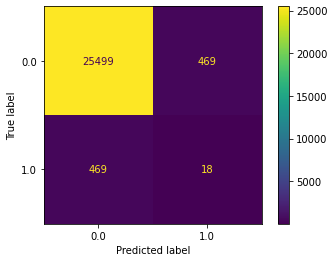

In [10]:
results(test_base, test_targets, high_risk_cutoff, head_model=head, data_set='Test')

The injury rate of apperances the model predicted to be high risk is: 0.0206756591796875
The injury rate of apperances the model did NOT predict to be high risk is: 0.0196380615234375
A pitcher is 1.052734375 times more likely to get injured when the 
 model predicts their appereance to be high risk versus when the model does NOT predict their appereance to be high risk
confusion matrix for Validation
The f1 score of the Validation data is: 0.019925280199252802
The recall of the Validation data is: 0.019230769230769232
The precision of the Validation data is: 0.020671834625323


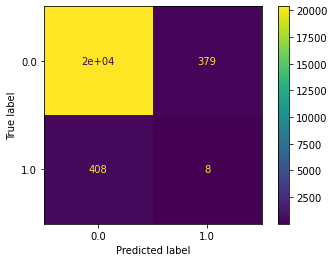

In [11]:
results(valid_base, valid_targets, high_risk_cutoff, head_model=head, data_set='Validation')

The injury rate of apperances the model predicted to be high risk is: 0.366455078125
The injury rate of apperances the model did NOT predict to be high risk is: 0.0122833251953125
A pitcher is 29.828125 times more likely to get injured when the 
 model predicts their appereance to be high risk versus when the model does NOT predict their appereance to be high risk
confusion matrix for Training
The f1 score of the Training data is: 0.3664596273291925
The recall of the Training data is: 0.36645962732919257
The precision of the Training data is: 0.36645962732919257


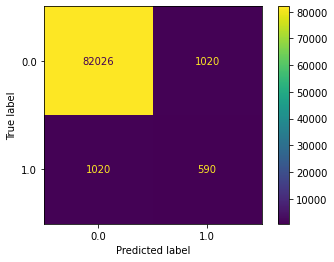

In [12]:
results(train_base, train_targets, high_risk_cutoff, head_model=head, data_set='Training')

In [13]:
df = pd.read_csv('/content/drive/MyDrive/data_490/processed_data/pandas_60_day')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (96,97,98,99,100,109,110,111,112,113,122,123,124,125,126) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
mlb = pd.read_csv('/content/drive/MyDrive/data_490/mlb.csv')

In [25]:
base_output = base_model.predict([ np.stack(ts_data['time_series'].values).astype(np.float16)[:,:,:-1], injury_history.iloc[:, 2:].astype(np.float16) ,bio_data.iloc[:, 2:].astype(np.float16)])

KeyboardInterrupt: ignored

In [29]:
preds = head.predict_proba(base_output, validate_features=False)
df['injury_prob'] = preds[:,1]

In [61]:
df['year'] = pd.DatetimeIndex(df.game_date).year

In [41]:
df['high_risk'] = df.apply(lambda row: 1 if row.injury_prob > high_risk_cutoff else 0, axis=1)

0.25668381693610864


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


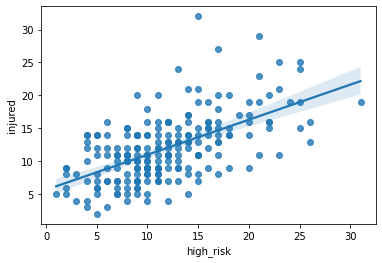

In [73]:
from sklearn import metrics
import seaborn as sns
team_high_risk = df.groupby(['team','year'])[['high_risk','injured']].sum().sort_values(by='high_risk',ascending=False)
print(metrics.r2_score(team_high_risk.high_risk, team_high_risk.injured))
sns.regplot(team_high_risk.high_risk, team_high_risk.injured)

In [107]:
team_high_risk.sort_values('high_risk', ascending=False).iloc[:10]

,,high_risk,injured
team,year,,
HOU,2021,31,19
ATL,2021,26,16
LAA,2017,26,13
STL,2021,25,19
WSH,2018,25,15
STL,2018,25,24
LAD,2021,25,25
SF,2021,24,19
TOR,2021,23,25


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


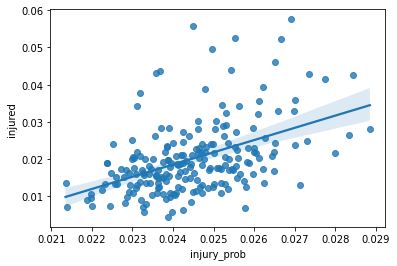

In [95]:
team_injury_risk = df.groupby(['team','year'])[['injury_prob','injured']].mean().sort_values(by='injury_prob',ascending=False)
sns.regplot(team_injury_risk.injury_prob, team_injury_risk.injured)

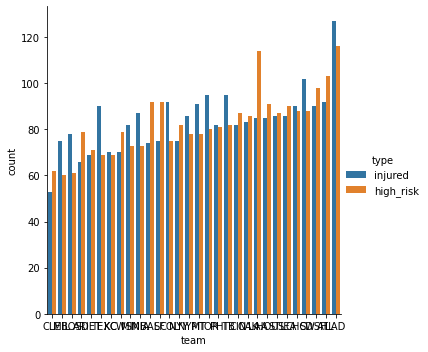

In [127]:
team_high_risk = df.groupby('team')[['high_risk','injured']].sum().reset_index()
team_high_risk_reshape = pd.melt(team_high_risk, id_vars='team',var_name='type', value_name='count').sort_values('count')
sns.catplot(x='team', y='count', hue='type', data=team_high_risk_reshape, kind='bar')

In [113]:
df.groupby('team')[['high_risk','injured']].sum()

,high_risk,injured
team,,
ARI,79,66
ATL,103,92
BAL,92,74
BOS,61,78
CHC,88,90
CIN,87,82
CLE,62,53
COL,75,92
CWS,79,70


In [66]:
df.groupby(['player_name','year'])[['high_risk','injured']].sum().sort_values(by='high_risk',ascending=False)

,,high_risk,injured
player_name,year,,
Bud Norris,2017,18,2
Ian Anderson,2021,14,4
José Castillo,2018,10,2
Andrew Cashner,2018,10,2
Jake Odorizzi,2021,9,2
...,...,...,...
Jon Heasley,2021,0,0
Jon Jay,2017,0,1
Jon Lester,2015,0,0


In [56]:
pitcher_apperances = df.groupby('player_name').injury_prob.size()
at_least_10 = pitcher_apperances[pitcher_apperances >= 10]
at_least_50 = pitcher_apperances[pitcher_apperances >= 30]
df[df.player_name.isin(at_least_50.index)].groupby('player_name')[['injury_prob','injured']].mean().sort_values(by='injury_prob',ascending=False).iloc[:25]

,injury_prob,injured
player_name,,
Ryan Vogelsong,0.052762,0.017544
Scott Kazmir,0.050920,0.048387
Phil Hughes,0.050807,0.065789
Jake Odorizzi,0.044339,0.050562
Johnny Cueto,0.043901,0.036765
Charlie Morton,0.043301,0.019108
Tyler Skaggs,0.042776,0.076923
Andrew Cashner,0.042753,0.038217
Tyler Chatwood,0.042442,0.050314


In [104]:
df[df.player_name.isin(at_least_10.index)].groupby(['player_name','year'])[['injury_prob','injured']].mean().sort_values(by='injury_prob',ascending=False).iloc[:20]

,,injury_prob,injured
player_name,year,,
Tyler Chatwood,2020,0.164995,0.400000
John Axford,2021,0.147925,1.000000
Scott Kazmir,2021,0.147447,0.200000
Steven Wright,2019,0.119399,0.250000
Ian Anderson,2021,0.111394,0.166667
Spencer Howard,2020,0.108254,0.166667
Charlie Morton,2016,0.107137,0.250000
Phil Coke,2016,0.103931,0.000000
Roberto Hernandez,2016,0.103185,0.000000


In [105]:
df[df.player_name.isin(at_least_10.index)].groupby(['player_name','year'])[['injury_prob','injured']].mean().sort_values(by='injury_prob',ascending=False).iloc[-20:]

,,injury_prob,injured
player_name,year,,
Blaine Hardy,2017,0.013476,0.000000
Blake Parker,2017,0.013444,0.000000
A.J. Minter,2019,0.013440,0.027778
Chris Devenski,2017,0.013434,0.000000
Randall Delgado,2016,0.013412,0.000000
Tyler Duffey,2017,0.013393,0.000000
Alex Colomé,2016,0.013216,0.017544
Aaron Nola,2021,0.013158,0.000000
Brent Suter,2021,0.013130,0.000000


In [80]:
df[df.player_name.isin(at_least_50.index)].groupby('player_name')[['high_risk','injured']].mean().sort_values(by='high_risk',ascending=True).iloc[:20]

,high_risk,injured
player_name,,
Elvis Araujo,0.0,0.013889
Eddie Butler,0.0,0.013158
Edgar García,0.0,0.000000
Ryan Mattheus,0.0,0.000000
Ryan Garton,0.0,0.000000
Ryan Dull,0.0,0.011765
Emilio Pagán,0.0,0.004098
Emmanuel Clase,0.0,0.000000
Enny Romero,0.0,0.022222


In [152]:
year_apperance_count = df.groupby(['player_name','year'])[['player_name','year']].size().reset_index()
year_apperance_count = year_apperance_count.rename(columns={0:'apperance_count'})
year_apperance_count = year_apperance_count[year_apperance_count.apperance_count >= 10]
year_injury_prob = df.groupby(['player_name','year'])[['injured','injury_prob']].mean().sort_values('injury_prob',ascending=True).reset_index()

In [153]:
player_year = year_injury_prob.merge(year_apperance_count, on=['player_name','year'], how='right')

In [172]:
player_year['season_injury'] = player_year.apply(lambda row: 1 if row.injured > 0 else 0, axis=1)

In [158]:
player_year

,player_name,year,injured,injury_prob,apperance_count
0,A.J. Achter,2015,0.000000,0.022904,11
1,A.J. Achter,2016,0.000000,0.018770,27
2,A.J. Burnett,2015,0.000000,0.021615,26
3,A.J. Cole,2017,0.000000,0.018373,11
4,A.J. Cole,2018,0.031250,0.023918,32
...,...,...,...,...,...
3755,Zack Wheeler,2017,0.117647,0.030192,17
3756,Zack Wheeler,2018,0.000000,0.027458,29
3757,Zack Wheeler,2019,0.032258,0.025287,31
3758,Zack Wheeler,2020,0.000000,0.026001,11


In [168]:
player_year['season_prob'] = 1 - ((1 - player_year.injury_prob)	** player_year.apperance_count)

In [176]:
player_year[player_year.high_risk_season == 0].sort_values('apperance_count', ascending=False)

,player_name,year,injured,injury_prob,apperance_count,season_prob,high_risk_season,season_injury
949,Danny Farquhar,2015,0.0,0.015862,43,0.497194,0,0
2879,Randy Rosario,2018,0.0,0.015757,42,0.486790,0,0
3738,Zack Britton,2018,0.0,0.016501,41,0.494494,0,0
1034,Derek Law,2017,0.0,0.014563,41,0.451998,0,0
992,David Phelps,2019,0.0,0.016738,41,0.499457,0,0
...,...,...,...,...,...,...,...,...
1859,John Means,2020,0.0,0.027347,10,0.242159,0,0
1809,Joe Nathan,2016,0.0,0.021955,10,0.199084,0,0
3460,Troy Scribner,2017,0.0,0.019806,10,0.181312,0,0
1761,Jimmy Nelson,2019,0.2,0.030064,10,0.263059,0,1


In [171]:
player_year['high_risk_season'] = player_year.apply(lambda row: 1 if row.season_prob > .5 else 0, axis=1)

In [173]:
metrics.f1_score(player_year['season_injury'], player_year['high_risk_season'])

0.5081110805609018